Simulate 200 data points according to the following:

$$ y = 4 * (X + 2 * Z) $$

where 

$$X \sim t(mu=0.5, sigma=1.2, nu=8)$$

and 

$$Z \sim N(0, 1)$$

and create a pymc3 model to infer the parameters (mu, sigma, nu) of the model.

Provide some descriptions and graphs of the parameters.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### Generating data

In [3]:
import scipy
from scipy import stats
RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
x=stats.t.rvs(8,loc = 0.5,scale = 1.2,size=200)
z = np.random.normal(0, 1,200)
y = 4 * (x + 2 * z)

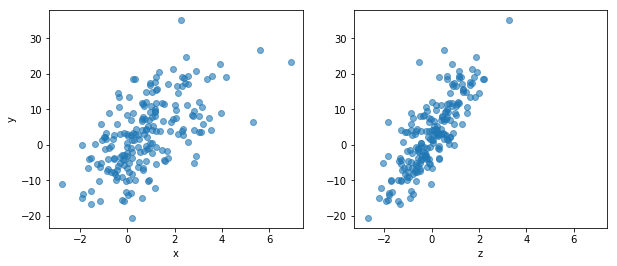

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(x, y, alpha=0.6)
axes[1].scatter(z, y, alpha=0.6)
axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[1].set_xlabel("z");

In [5]:
x.mean()

0.7976296305173282

In [6]:
x.std()

1.474312980643161

In [7]:
y.mean()

2.997470721318935

In [8]:
y.std()

9.92619159529874

### Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 


In [9]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    sigma = pm.HalfNormal("sigma", sigma=1.2)
    mu = pm.Normal("mu", mu=0.5,sigma=1.2)
    nu=pm.Binomial("nu", n=16,p=0.5)
    
    y = pm.StudentT("y",nu=nu, mu=mu, sigma=sigma, observed=y)
    # Expected value of outcome
    y = 4 * x + 8 * z

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [10]:
# model fitting
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'sigma_log__': array(2.0685848),
 'mu': array(2.2427046),
 'nu': array(8, dtype=int64),
 'sigma': array(7.91361585)}

In [11]:
# sampling method , return_inferencedata=False
with basic_model:
    trace = pm.sample(200)

Only 200 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 395 seconds.
The number of effective samples is smaller than 25% for some parameters.


The `sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the variables as follows:

In [12]:
trace["nu"][-5:]

array([7, 7, 7, 7, 7], dtype=int64)

In [13]:
trace["mu"][-5:]

array([2.10351263, 2.74247755, 3.11844852, 2.88631521, 2.79983353])

In [14]:
trace["sigma"][-5:]

array([7.62304251, 7.91121797, 8.12708694, 8.13045369, 8.08100333])

### Posterior analysis
`PyMC3`'s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named [ArviZ](https://arviz-devs.github.io/arviz/). A simple posterior plot can be created using `plot_trace`.

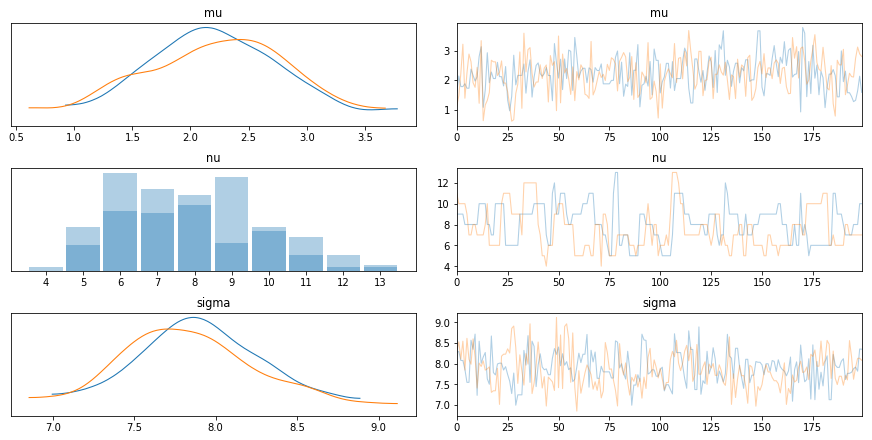

In [15]:
# Posterior analysis
with basic_model:
    az.plot_trace(trace);

The left side shows our marginal posterior – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data.


In [16]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.21,0.60,1.04,3.24,0.04,0.03,190.53,190.53,192.42,252.54,1.01
nu,7.86,1.92,5.00,11.00,0.20,0.14,88.21,88.21,89.04,93.21,1.02
sigma,7.88,0.41,7.17,8.74,0.03,0.02,202.54,202.47,204.58,191.80,1.01
